In [1]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [1]:
import os
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [2]:
os.chdir('..')
# os.chdir('drive/My Drive/Colab Notebooks/Github/fashion-recommendations') 

In [3]:
from fashion_recommendations.metrics.average_precision import mapk

In [4]:
pd.options.display.max_columns = None

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Load transactions

In [6]:
train_set_orig = pd.read_csv('data/splits/train_subset.tsv', sep='\t', dtype={'article_id': str}, usecols=['t_dat', 'customer_id', 'article_id'])
print(train_set_orig.shape)
train_set_orig.head()

(588758, 3)


,t_dat,customer_id,article_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023
2,2018-09-20,016d8f0519d9e0572b3abebeab87408bad7a5c3a284016...,0650193004
3,2018-09-20,016d8f0519d9e0572b3abebeab87408bad7a5c3a284016...,0527687006
4,2018-09-20,02bfe1a5248beb9cd28ad4ac630a6d75e78d9a3e14551a...,0668767002


In [7]:
test_set = pd.read_csv('data/splits/test_subset.tsv', sep='\t', dtype={'article_id': str}, usecols=['t_dat', 'customer_id', 'article_id'])
print(test_set.shape)
test_set.head()

(32995, 3)


,t_dat,customer_id,article_id
0,2020-09-15,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007
1,2020-09-15,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,0778745010
2,2020-09-15,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,0778745010
3,2020-09-15,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,0610776105
4,2020-09-15,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,0929745001


Only include articles bought after 2020-01:

In [8]:
train_set_orig['t_dat'] = pd.to_datetime(train_set_orig['t_dat'])

In [9]:
article_id_to_keep = train_set_orig[train_set_orig['t_dat'] > '2020-01-01']['article_id'].unique()

In [10]:
print(train_set_orig.shape)
train_set_orig = train_set_orig.copy()[train_set_orig['article_id'].isin(article_id_to_keep)]
print(train_set_orig.shape)

(588758, 3)
(395219, 3)


### Load customer features

In [11]:
customers = pd.read_csv('data/customers.csv')
print(customers.shape)
customers.head()

(1371980, 7)


,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [12]:
customers.isnull().sum() / customers.shape[0]

customer_id               0.000000
FN                        0.652378
Active                    0.661508
club_member_status        0.004418
fashion_news_frequency    0.011669
age                       0.011561
postal_code               0.000000
dtype: float64

In [13]:
customers[['FN', 'Active']] = customers[['FN', 'Active']].fillna(0)

In [14]:
customers['club_member_status'] = customers['club_member_status'].str.lower().str.replace('-', '_').str.replace(' ', '_').fillna('missing')

In [15]:
customers['fashion_news_frequency'] = customers['fashion_news_frequency'].str.lower().str.replace('-', '_').str.replace(' ', '_').fillna('missing')

In [16]:
customers['fashion_news_frequency'] = customers['fashion_news_frequency'].replace('none', 'missing')

In [17]:
customers.isnull().sum()

customer_id                   0
FN                            0
Active                        0
club_member_status            0
fashion_news_frequency        0
age                       15861
postal_code                   0
dtype: int64

In [18]:
customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.0,0.0,active,missing,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0.0,0.0,active,missing,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.0,0.0,active,missing,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.0,0.0,active,missing,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,active,regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [19]:
for col in customers.columns:
    print(col)
    print(customers[col].nunique())

customer_id
1371980
FN
2
Active
2
club_member_status
4
fashion_news_frequency
3
age
84
postal_code
352899


In [20]:
customers.drop('postal_code', axis=1, inplace=True)

In [21]:
customers = pd.get_dummies(customers, columns=['FN', 'Active'], drop_first=True)

In [22]:
customers = pd.get_dummies(customers, columns=['club_member_status', 'fashion_news_frequency'])

In [23]:
customers.head()

,customer_id,age,FN_1.0,Active_1.0,club_member_status_active,club_member_status_left_club,club_member_status_missing,club_member_status_pre_create,fashion_news_frequency_missing,fashion_news_frequency_monthly,fashion_news_frequency_regularly
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,49.0,0,0,1,0,0,0,1,0,0
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,25.0,0,0,1,0,0,0,1,0,0
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,24.0,0,0,1,0,0,0,1,0,0
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,54.0,0,0,1,0,0,0,1,0,0
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,52.0,1,1,1,0,0,0,0,0,1


### Load article features

In [24]:
articles_df = pd.read_csv(
    'data/articles.csv', 
    dtype={'article_id': str}, 
)
print(articles_df.shape)
articles_df.head()

(105542, 25)


,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,0108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,0108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,3,Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,0108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,1,Dusty Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,0110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,4,Dark,5,Black,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,0110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,3,Light,9,White,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [25]:
for col in articles_df.columns:    
    if articles_df[col].nunique() <= 10:
        print(col)

perceived_colour_value_id
perceived_colour_value_name
index_code
index_name
index_group_no
index_group_name


In [26]:
cols_to_keep = [
    'article_id',
    'perceived_colour_value_name',
    'index_name',
    'index_group_name'
]

In [27]:
articles_df = articles_df.copy()[cols_to_keep]
articles_df = pd.get_dummies(articles_df, columns=['perceived_colour_value_name', 'index_name', 'index_group_name'])

print(articles_df.shape)
articles_df.head()

(105542, 24)


,article_id,perceived_colour_value_name_Bright,perceived_colour_value_name_Dark,perceived_colour_value_name_Dusty Light,perceived_colour_value_name_Light,perceived_colour_value_name_Medium,perceived_colour_value_name_Medium Dusty,perceived_colour_value_name_Undefined,perceived_colour_value_name_Unknown,index_name_Baby Sizes 50-98,"index_name_Children Accessories, Swimwear",index_name_Children Sizes 134-170,index_name_Children Sizes 92-140,index_name_Divided,index_name_Ladies Accessories,index_name_Ladieswear,index_name_Lingeries/Tights,index_name_Menswear,index_name_Sport,index_group_name_Baby/Children,index_group_name_Divided,index_group_name_Ladieswear,index_group_name_Menswear,index_group_name_Sport
0,0108775015,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
1,0108775044,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
2,0108775051,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,0110065001,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
4,0110065002,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0


### Train-dev split

In [28]:
end = train_set_orig['t_dat'].max()
endm1 = end - datetime.timedelta(days=7)

endm1, end

(Timestamp('2020-09-07 00:00:00'), Timestamp('2020-09-14 00:00:00'))

In [29]:
train_set = train_set_orig.copy()[train_set_orig['t_dat'] < endm1]

dev_set = train_set_orig.copy()[train_set_orig['t_dat'] >= endm1]

train_set.drop(columns=['t_dat'], inplace=True)
dev_set.drop(columns=['t_dat'], inplace=True)

train_set.shape, dev_set.shape

((386856, 2), (8363, 2))

### Generate negative samples

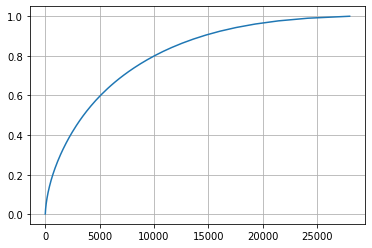

In [30]:
plt.plot((train_set.groupby('article_id')['customer_id'].count() / train_set.shape[0]).sort_values(ascending=False).cumsum().values)
plt.grid()
plt.show()

In [31]:
articles_df['article_id'].nunique()

105542

Draw samples from top-10000 items in training set

In [32]:
TOP_K = 1000

In [33]:
top_k_articles = train_set['article_id'].value_counts().sort_values(ascending=False).head(TOP_K).index.tolist()
top_k_articles[:5]

['0706016001', '0706016002', '0372860001', '0610776002', '0759871002']

In [34]:
def negative_samples(excl):
    samples = set(np.random.choice(top_k_articles, size=1000, replace=False))
    neg_samples = samples - set(excl)
    return list(neg_samples)

Train set

In [35]:
train_set.head()

,customer_id,article_id
10,02d796ea767fa2e94fc6228fe70d8af1a570da973c32f7...,0564358010
17,02d796ea767fa2e94fc6228fe70d8af1a570da973c32f7...,0575347003
27,03126e45c08e82cd192b32cbddbeba63387e11e5531059...,0573652001
40,08e5ec1f652c85fc59be204b60f262b6d1f45e4ce11872...,0573937001
43,09bca14258b7e9b9ee968adffe54d45c1e370e8ed79a22...,0579541001


In [36]:
purchases_by_customer_id = train_set.groupby('customer_id')['article_id'].apply(lambda x: list(x)).reset_index()
purchases_by_customer_id.head()

,customer_id,article_id
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,"[0723529001, 0351484002, 0351484002, 072780800..."
1,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,"[0684210001, 0714029002, 0713991002, 049568500..."
2,00282135561702f5b3b750fa3382d8fd83ce5d761a507e...,"[0570002001, 0567418036, 0762287001, 077081600..."
3,00356a94bb9bed341f6dba58ad722974b01a1cbd9f06ef...,[0657014002]
4,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,"[0201219001, 0322017003, 0156231001, 075475100..."


In [37]:
%%time
purchases_by_customer_id['negative_samples'] = purchases_by_customer_id['article_id'].apply(negative_samples)

CPU times: user 5.18 s, sys: 427 ms, total: 5.61 s
Wall time: 5.63 s


In [38]:
purchases_by_customer_id.head()

,customer_id,article_id,negative_samples
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,"[0723529001, 0351484002, 0351484002, 072780800...","[0754910001, 0579541004, 0824337001, 074363000..."
1,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,"[0684210001, 0714029002, 0713991002, 049568500...","[0754910001, 0579541004, 0824337001, 074363000..."
2,00282135561702f5b3b750fa3382d8fd83ce5d761a507e...,"[0570002001, 0567418036, 0762287001, 077081600...","[0579541004, 0754910001, 0824337001, 074363000..."
3,00356a94bb9bed341f6dba58ad722974b01a1cbd9f06ef...,[0657014002],"[0579541004, 0754910001, 0824337001, 074363000..."
4,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,"[0201219001, 0322017003, 0156231001, 075475100...","[0754910001, 0579541004, 0824337001, 074363000..."


In [39]:
negative_samples_df = purchases_by_customer_id[['customer_id', 'negative_samples']].explode('negative_samples')
negative_samples_df.head()

,customer_id,negative_samples
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0754910001
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0579541004
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0824337001
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0743630007
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0538699007


In [40]:
negative_samples_df.rename(columns={'negative_samples': 'article_id'}, inplace=True)
negative_samples_df['purchased'] = 0
negative_samples_df.head()

,customer_id,article_id,purchased
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0754910001,0
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0579541004,0
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0824337001,0
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0743630007,0
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0538699007,0


In [41]:
train_set['purchased'] = 1
train_set.head()

,customer_id,article_id,purchased
10,02d796ea767fa2e94fc6228fe70d8af1a570da973c32f7...,0564358010,1
17,02d796ea767fa2e94fc6228fe70d8af1a570da973c32f7...,0575347003,1
27,03126e45c08e82cd192b32cbddbeba63387e11e5531059...,0573652001,1
40,08e5ec1f652c85fc59be204b60f262b6d1f45e4ce11872...,0573937001,1
43,09bca14258b7e9b9ee968adffe54d45c1e370e8ed79a22...,0579541001,1


In [42]:
train_set = pd.concat([
    train_set,
    negative_samples_df
])

train_set = train_set.sample(frac=1)  # shuffle
print(train_set.shape)
train_set.head()

(9363278, 3)


,customer_id,article_id,purchased
98,0259be0fa217481e32e7a1f35ec2b9fe7e5c815b3db235...,0688537011,0
880,198b675a1dc60ae6144b7d872dab64cee8513462c39b1f...,0817353008,0
4043,70bf9dc18f2f8459c89b3ffca7effd2c2d79dd33f3d105...,0554598001,0
1022,1d2b066b0884476e071e4fbdf98108eb64d12e92c8e649...,0723347001,0
1620,2cc74e4f026dd9a3e9fd61bde5521d5688f395d6fcebe3...,0570003002,0


In [43]:
train_set['purchased'].mean()

0.041316299697605904

Dev set

In [44]:
dev_set.head()

,customer_id,article_id
580395,00639e775b90554156986100685c4d408723c77e411e37...,0891591007
580396,00639e775b90554156986100685c4d408723c77e411e37...,0891591001
580397,016f3b7c2b7652870b4b2dbdcb1805a7c8c262036f5511...,0909924004
580398,016f3b7c2b7652870b4b2dbdcb1805a7c8c262036f5511...,0921266005
580399,016f3b7c2b7652870b4b2dbdcb1805a7c8c262036f5511...,0857163001


In [45]:
purchases_by_customer_id = dev_set.groupby('customer_id')['article_id'].apply(lambda x: list(x)).reset_index()
purchases_by_customer_id.head()

,customer_id,article_id
0,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,[0903924001]
1,0054c50274d19af58d53ef3ce0c004bea446c80bd51cf2...,"[0766346011, 0568601043, 0763037001]"
2,00639e775b90554156986100685c4d408723c77e411e37...,"[0891591007, 0891591001, 0891591001]"
3,00798bd464457d23d6af401715fe32d5c676ad9ee4010d...,[0916775002]
4,0099238196d8f71659fceaa115b36e400398bcfc169b5f...,"[0867969003, 0867969003, 0448509014, 088290001..."


In [46]:
%%time
purchases_by_customer_id['negative_samples'] = purchases_by_customer_id['article_id'].apply(negative_samples)

CPU times: user 1.07 s, sys: 65.7 ms, total: 1.14 s
Wall time: 1.14 s


In [47]:
purchases_by_customer_id.head()

,customer_id,article_id,negative_samples
0,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,[0903924001],"[0754910001, 0579541004, 0824337001, 074363000..."
1,0054c50274d19af58d53ef3ce0c004bea446c80bd51cf2...,"[0766346011, 0568601043, 0763037001]","[0579541004, 0754910001, 0824337001, 074363000..."
2,00639e775b90554156986100685c4d408723c77e411e37...,"[0891591007, 0891591001, 0891591001]","[0754910001, 0579541004, 0824337001, 074363000..."
3,00798bd464457d23d6af401715fe32d5c676ad9ee4010d...,[0916775002],"[0579541004, 0754910001, 0824337001, 074363000..."
4,0099238196d8f71659fceaa115b36e400398bcfc169b5f...,"[0867969003, 0867969003, 0448509014, 088290001...","[0754910001, 0579541004, 0824337001, 074363000..."


In [48]:
negative_samples_df = purchases_by_customer_id[['customer_id', 'negative_samples']].explode('negative_samples')
negative_samples_df.head()

,customer_id,negative_samples
0,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,0754910001
0,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,0579541004
0,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,0824337001
0,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,0743630007
0,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,0538699007


In [49]:
negative_samples_df.rename(columns={'negative_samples': 'article_id'}, inplace=True)
negative_samples_df['purchased'] = 0
negative_samples_df.head()

,customer_id,article_id,purchased
0,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,0754910001,0
0,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,0579541004,0
0,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,0824337001,0
0,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,0743630007,0
0,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,0538699007,0


In [50]:
dev_set['purchased'] = 1
dev_set.head()

,customer_id,article_id,purchased
580395,00639e775b90554156986100685c4d408723c77e411e37...,0891591007,1
580396,00639e775b90554156986100685c4d408723c77e411e37...,0891591001,1
580397,016f3b7c2b7652870b4b2dbdcb1805a7c8c262036f5511...,0909924004,1
580398,016f3b7c2b7652870b4b2dbdcb1805a7c8c262036f5511...,0921266005,1
580399,016f3b7c2b7652870b4b2dbdcb1805a7c8c262036f5511...,0857163001,1


In [51]:
dev_set = pd.concat([
    dev_set,
    negative_samples_df
])

dev_set = dev_set.sample(frac=1)  # shuffle
print(dev_set.shape)
dev_set.head()

(2005559, 3)


,customer_id,article_id,purchased
86,0cf9646ee12cdf843eb90c27f1aa57a19afb08b21c1a60...,0781813002,0
1566,ca809c3c0825ab93081f28a4480584659b815844549b5c...,0783346016,0
1685,d953ebaa3bd563fe98d4b4fbf13a97293707a39452fecb...,0712216005,0
1699,da8e753500e68fc1a629d04fac2ea0f33856cfc58b6c92...,0762205003,0
106,0fe04e6924eb6c5cfff09f31240bba031ac8e112e84bd1...,0768921001,0


In [52]:
dev_set.groupby('purchased')['customer_id'].count()

purchased
0    1997196
1       8363
Name: customer_id, dtype: int64

In [53]:
dev_set['purchased'].mean()

0.0041699097358890965

In [54]:
train_set['purchased'].mean()

0.041316299697605904

### Merge features

In [55]:
train_set = (
    train_set
    .merge(customers, on='customer_id', how='left')
    .merge(articles_df, on='article_id', how='left')
)
print(train_set.shape)
train_set.head()

(9363278, 36)


,customer_id,article_id,purchased,age,FN_1.0,Active_1.0,club_member_status_active,club_member_status_left_club,club_member_status_missing,club_member_status_pre_create,fashion_news_frequency_missing,fashion_news_frequency_monthly,fashion_news_frequency_regularly,perceived_colour_value_name_Bright,perceived_colour_value_name_Dark,perceived_colour_value_name_Dusty Light,perceived_colour_value_name_Light,perceived_colour_value_name_Medium,perceived_colour_value_name_Medium Dusty,perceived_colour_value_name_Undefined,perceived_colour_value_name_Unknown,index_name_Baby Sizes 50-98,"index_name_Children Accessories, Swimwear",index_name_Children Sizes 134-170,index_name_Children Sizes 92-140,index_name_Divided,index_name_Ladies Accessories,index_name_Ladieswear,index_name_Lingeries/Tights,index_name_Menswear,index_name_Sport,index_group_name_Baby/Children,index_group_name_Divided,index_group_name_Ladieswear,index_group_name_Menswear,index_group_name_Sport
0,0259be0fa217481e32e7a1f35ec2b9fe7e5c815b3db235...,0688537011,0,57.0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1,198b675a1dc60ae6144b7d872dab64cee8513462c39b1f...,0817353008,0,33.0,1,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
2,70bf9dc18f2f8459c89b3ffca7effd2c2d79dd33f3d105...,0554598001,0,58.0,1,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,1d2b066b0884476e071e4fbdf98108eb64d12e92c8e649...,0723347001,0,20.0,1,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
4,2cc74e4f026dd9a3e9fd61bde5521d5688f395d6fcebe3...,0570003002,0,25.0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [56]:
dev_set = (
    dev_set
    .merge(customers, on='customer_id', how='left')
    .merge(articles_df, on='article_id', how='left')
)
print(dev_set.shape)
dev_set.head()

(2005559, 36)


,customer_id,article_id,purchased,age,FN_1.0,Active_1.0,club_member_status_active,club_member_status_left_club,club_member_status_missing,club_member_status_pre_create,fashion_news_frequency_missing,fashion_news_frequency_monthly,fashion_news_frequency_regularly,perceived_colour_value_name_Bright,perceived_colour_value_name_Dark,perceived_colour_value_name_Dusty Light,perceived_colour_value_name_Light,perceived_colour_value_name_Medium,perceived_colour_value_name_Medium Dusty,perceived_colour_value_name_Undefined,perceived_colour_value_name_Unknown,index_name_Baby Sizes 50-98,"index_name_Children Accessories, Swimwear",index_name_Children Sizes 134-170,index_name_Children Sizes 92-140,index_name_Divided,index_name_Ladies Accessories,index_name_Ladieswear,index_name_Lingeries/Tights,index_name_Menswear,index_name_Sport,index_group_name_Baby/Children,index_group_name_Divided,index_group_name_Ladieswear,index_group_name_Menswear,index_group_name_Sport
0,0cf9646ee12cdf843eb90c27f1aa57a19afb08b21c1a60...,0781813002,0,20.0,1,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
1,ca809c3c0825ab93081f28a4480584659b815844549b5c...,0783346016,0,46.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
2,d953ebaa3bd563fe98d4b4fbf13a97293707a39452fecb...,0712216005,0,56.0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,da8e753500e68fc1a629d04fac2ea0f33856cfc58b6c92...,0762205003,0,31.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,0fe04e6924eb6c5cfff09f31240bba031ac8e112e84bd1...,0768921001,0,36.0,1,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0


### Impute `NULL`s

In [57]:
train_set.isnull().sum()[train_set.isnull().sum() > 0]

age    37524
dtype: int64

In [58]:
dev_set.isnull().sum()[dev_set.isnull().sum() > 0]

age    7023
dtype: int64

In [59]:
from sklearn.impute import SimpleImputer

In [60]:
age_imputer = SimpleImputer()

In [61]:
age_imputer.fit(train_set['age'].values.reshape(-1, 1))

SimpleImputer()

In [62]:
train_set['age'] = age_imputer.transform(train_set['age'].values.reshape(-1, 1))

In [63]:
dev_set['age'] = age_imputer.transform(dev_set['age'].values.reshape(-1, 1))

### Train LGBMRanker

Based on https://stackoverflow.com/questions/64294962/how-to-implement-learning-to-rank-using-lightgbm

In [64]:
import re

In [65]:
train_set.columns = [re.sub(r'[^\w\s]','',s).replace(' ', '') for s in train_set.columns]
dev_set.columns = [re.sub(r'[^\w\s]','',s).replace(' ', '') for s in dev_set.columns]

In [66]:
train_set.sort_values('customer_id', inplace=True)
train_set.head()

,customer_id,article_id,purchased,age,FN_10,Active_10,club_member_status_active,club_member_status_left_club,club_member_status_missing,club_member_status_pre_create,fashion_news_frequency_missing,fashion_news_frequency_monthly,fashion_news_frequency_regularly,perceived_colour_value_name_Bright,perceived_colour_value_name_Dark,perceived_colour_value_name_DustyLight,perceived_colour_value_name_Light,perceived_colour_value_name_Medium,perceived_colour_value_name_MediumDusty,perceived_colour_value_name_Undefined,perceived_colour_value_name_Unknown,index_name_BabySizes5098,index_name_ChildrenAccessoriesSwimwear,index_name_ChildrenSizes134170,index_name_ChildrenSizes92140,index_name_Divided,index_name_LadiesAccessories,index_name_Ladieswear,index_name_LingeriesTights,index_name_Menswear,index_name_Sport,index_group_name_BabyChildren,index_group_name_Divided,index_group_name_Ladieswear,index_group_name_Menswear,index_group_name_Sport
1113095,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0464297021,0,24.0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
8489817,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0512251003,0,24.0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
6848742,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0717773001,0,24.0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
7334261,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0658030017,0,24.0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
7506226,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0716348004,0,24.0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0


In [67]:
dev_set.sort_values('customer_id', inplace=True)
dev_set.head()

,customer_id,article_id,purchased,age,FN_10,Active_10,club_member_status_active,club_member_status_left_club,club_member_status_missing,club_member_status_pre_create,fashion_news_frequency_missing,fashion_news_frequency_monthly,fashion_news_frequency_regularly,perceived_colour_value_name_Bright,perceived_colour_value_name_Dark,perceived_colour_value_name_DustyLight,perceived_colour_value_name_Light,perceived_colour_value_name_Medium,perceived_colour_value_name_MediumDusty,perceived_colour_value_name_Undefined,perceived_colour_value_name_Unknown,index_name_BabySizes5098,index_name_ChildrenAccessoriesSwimwear,index_name_ChildrenSizes134170,index_name_ChildrenSizes92140,index_name_Divided,index_name_LadiesAccessories,index_name_Ladieswear,index_name_LingeriesTights,index_name_Menswear,index_name_Sport,index_group_name_BabyChildren,index_group_name_Divided,index_group_name_Ladieswear,index_group_name_Menswear,index_group_name_Sport
1990673,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,0685814001,0,24.0,1,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1723906,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,0660726001,0,24.0,1,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
1225071,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,0790096002,0,24.0,1,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
589511,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,0810838010,0,24.0,1,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
1787738,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,0717464002,0,24.0,1,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0


In [68]:
qids_train = train_set.groupby("customer_id")["customer_id"].count().to_numpy()
X_train = train_set.drop(["customer_id", "article_id", "purchased"], axis=1)
y_train = train_set["purchased"]

qids_dev = dev_set.groupby("customer_id")["customer_id"].count().to_numpy()
X_dev = dev_set.drop(["customer_id", "article_id", "purchased"], axis=1)
y_dev = dev_set["purchased"]

In [69]:
import lightgbm

In [70]:
model = lightgbm.LGBMRanker(
    objective="lambdarank",
    metric="map"  # "ndcg",
)

In [71]:
%%time
model.fit(
    X=X_train,
    y=y_train,
    group=qids_train,
    eval_set=[(X_dev, y_dev)],
    eval_group=[qids_dev],
    eval_at=12,
    verbose=10,
)

/Users/stevengeorge/opt/anaconda3/envs/fashion_rec/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's map@12: 0.0628521
[20]	valid_0's map@12: 0.0629056
[30]	valid_0's map@12: 0.06432
[40]	valid_0's map@12: 0.0643897
[50]	valid_0's map@12: 0.0644476
[60]	valid_0's map@12: 0.0646413
[70]	valid_0's map@12: 0.0644546
[80]	valid_0's map@12: 0.0643886
[90]	valid_0's map@12: 0.0643374
[100]	valid_0's map@12: 0.0647683
CPU times: user 6min 5s, sys: 8.88 s, total: 6min 14s
Wall time: 58.3 s


LGBMRanker(metric='map', objective='lambdarank')

In [72]:
predictions_dev = model.predict(X_dev)

In [73]:
dev_set['predictions'] = predictions_dev

In [74]:
predictions_list = (
    dev_set
    .sort_values(['customer_id', 'predictions'], ascending=False)
    .groupby('customer_id').head(12)
    .groupby('customer_id')['article_id'].apply(lambda x: list(x)).reset_index()
)
predictions_list.head()

,customer_id,article_id
0,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,"[0903924001, 0743098001, 0523490003, 074309800..."
1,0054c50274d19af58d53ef3ce0c004bea446c80bd51cf2...,"[0743098001, 0857812004, 0763280008, 052349000..."
2,00639e775b90554156986100685c4d408723c77e411e37...,"[0743098001, 0857812004, 0763280008, 074309800..."
3,00798bd464457d23d6af401715fe32d5c676ad9ee4010d...,"[0743098001, 0857812004, 0763280008, 067869200..."
4,0099238196d8f71659fceaa115b36e400398bcfc169b5f...,"[0743098001, 0763280008, 0857812004, 076265600..."


In [75]:
actuals_list = dev_set[dev_set['purchased'] == 1].groupby('customer_id')['article_id'].apply(lambda x: list(x)).reset_index()
actuals_list.head()

,customer_id,article_id
0,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,[0903924001]
1,0054c50274d19af58d53ef3ce0c004bea446c80bd51cf2...,"[0568601043, 0766346011, 0763037001]"
2,00639e775b90554156986100685c4d408723c77e411e37...,"[0891591001, 0891591007, 0891591001]"
3,00798bd464457d23d6af401715fe32d5c676ad9ee4010d...,[0916775002]
4,0099238196d8f71659fceaa115b36e400398bcfc169b5f...,"[0857924011, 0694848001, 0867969003, 088290000..."


In [76]:
predictions_list.shape, actuals_list.shape

((1998, 2), (1998, 2))

In [77]:
predictions_df = predictions_list.merge(actuals_list, on='customer_id', suffixes=('_pred', '_act'))
predictions_df.head()

,customer_id,article_id_pred,article_id_act
0,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,"[0903924001, 0743098001, 0523490003, 074309800...",[0903924001]
1,0054c50274d19af58d53ef3ce0c004bea446c80bd51cf2...,"[0743098001, 0857812004, 0763280008, 052349000...","[0568601043, 0766346011, 0763037001]"
2,00639e775b90554156986100685c4d408723c77e411e37...,"[0743098001, 0857812004, 0763280008, 074309800...","[0891591001, 0891591007, 0891591001]"
3,00798bd464457d23d6af401715fe32d5c676ad9ee4010d...,"[0743098001, 0857812004, 0763280008, 067869200...",[0916775002]
4,0099238196d8f71659fceaa115b36e400398bcfc169b5f...,"[0743098001, 0763280008, 0857812004, 076265600...","[0857924011, 0694848001, 0867969003, 088290000..."


In [78]:
mapk(predictions_df['article_id_act'], predictions_df['article_id_pred'], k=12)

0.06041193506877129

### Test set evaluation

In [79]:
test_actuals = test_set.groupby('customer_id')['article_id'].apply(lambda x: list(x)).reset_index()
test_actuals.head()

,customer_id,article_id
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,[0794321007]
1,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,"[0778745010, 0778745010, 0610776105, 092974500..."
2,00282135561702f5b3b750fa3382d8fd83ce5d761a507e...,"[0855249006, 0822171001]"
3,00356a94bb9bed341f6dba58ad722974b01a1cbd9f06ef...,"[0920012003, 0572797002, 0572797002, 056860104..."
4,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,"[0827968001, 0887757001, 0673677002, 079936500..."


In [80]:
test_customers = test_actuals[['customer_id']]
test_customers['join_key'] = 1

In [81]:
len(top_k_articles)

1000

In [82]:
top_k_articles_df = pd.DataFrame(top_k_articles, columns=['article_id'])
top_k_articles_df['join_key'] = 1

In [83]:
test_customers = test_customers.merge(top_k_articles_df, on='join_key').drop(columns='join_key')
print(test_customers.shape)
test_customers.head()

(9208000, 2)


,customer_id,article_id
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0706016001
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0706016002
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0372860001
3,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0610776002
4,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0759871002


In [84]:
test_customers = (
    test_customers
    .merge(customers, on='customer_id', how='left')
    .merge(articles_df, on='article_id', how='left')
)
print(test_customers.shape)
test_customers.head()

(9208000, 35)


,customer_id,article_id,age,FN_1.0,Active_1.0,club_member_status_active,club_member_status_left_club,club_member_status_missing,club_member_status_pre_create,fashion_news_frequency_missing,fashion_news_frequency_monthly,fashion_news_frequency_regularly,perceived_colour_value_name_Bright,perceived_colour_value_name_Dark,perceived_colour_value_name_Dusty Light,perceived_colour_value_name_Light,perceived_colour_value_name_Medium,perceived_colour_value_name_Medium Dusty,perceived_colour_value_name_Undefined,perceived_colour_value_name_Unknown,index_name_Baby Sizes 50-98,"index_name_Children Accessories, Swimwear",index_name_Children Sizes 134-170,index_name_Children Sizes 92-140,index_name_Divided,index_name_Ladies Accessories,index_name_Ladieswear,index_name_Lingeries/Tights,index_name_Menswear,index_name_Sport,index_group_name_Baby/Children,index_group_name_Divided,index_group_name_Ladieswear,index_group_name_Menswear,index_group_name_Sport
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0706016001,24.0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0706016002,24.0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0372860001,24.0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
3,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0610776002,24.0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0759871002,24.0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0


In [85]:
test_customers['age'] = age_imputer.transform(test_customers['age'].values.reshape(-1, 1))

In [86]:
test_predictions = model.predict(
    test_customers.drop(["customer_id", "article_id"], axis=1)
)

In [87]:
test_customers['predictions'] = test_predictions

In [88]:
test_customers.head()

,customer_id,article_id,age,FN_1.0,Active_1.0,club_member_status_active,club_member_status_left_club,club_member_status_missing,club_member_status_pre_create,fashion_news_frequency_missing,fashion_news_frequency_monthly,fashion_news_frequency_regularly,perceived_colour_value_name_Bright,perceived_colour_value_name_Dark,perceived_colour_value_name_Dusty Light,perceived_colour_value_name_Light,perceived_colour_value_name_Medium,perceived_colour_value_name_Medium Dusty,perceived_colour_value_name_Undefined,perceived_colour_value_name_Unknown,index_name_Baby Sizes 50-98,"index_name_Children Accessories, Swimwear",index_name_Children Sizes 134-170,index_name_Children Sizes 92-140,index_name_Divided,index_name_Ladies Accessories,index_name_Ladieswear,index_name_Lingeries/Tights,index_name_Menswear,index_name_Sport,index_group_name_Baby/Children,index_group_name_Divided,index_group_name_Ladieswear,index_group_name_Menswear,index_group_name_Sport,predictions
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0706016001,24.0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,-0.437454
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0706016002,24.0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,-0.226120
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0372860001,24.0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,-0.666705
3,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0610776002,24.0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,-0.703999
4,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0759871002,24.0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,-0.437454


In [89]:
test_predictions_df = (
    test_customers
    .sort_values(['customer_id', 'predictions'], ascending=False)
    .groupby('customer_id').head(12)
    .groupby('customer_id')['article_id'].apply(lambda x: list(x)).reset_index()
)
test_predictions_df.head()

,customer_id,article_id
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,"[0743098001, 0743098002, 0523490003, 085781200..."
1,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,"[0743098001, 0857812004, 0763280008, 074309800..."
2,00282135561702f5b3b750fa3382d8fd83ce5d761a507e...,"[0857812004, 0763280008, 0743098001, 076328000..."
3,00356a94bb9bed341f6dba58ad722974b01a1cbd9f06ef...,"[0743098001, 0857812004, 0763280008, 055653901..."
4,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,"[0743098001, 0743098002, 0523490003, 085781200..."


In [90]:
predictions_df = test_predictions_df.merge(test_actuals, on='customer_id', suffixes=('_pred', '_act'))
predictions_df.head()

,customer_id,article_id_pred,article_id_act
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,"[0743098001, 0743098002, 0523490003, 085781200...",[0794321007]
1,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,"[0743098001, 0857812004, 0763280008, 074309800...","[0778745010, 0778745010, 0610776105, 092974500..."
2,00282135561702f5b3b750fa3382d8fd83ce5d761a507e...,"[0857812004, 0763280008, 0743098001, 076328000...","[0855249006, 0822171001]"
3,00356a94bb9bed341f6dba58ad722974b01a1cbd9f06ef...,"[0743098001, 0857812004, 0763280008, 055653901...","[0920012003, 0572797002, 0572797002, 056860104..."
4,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,"[0743098001, 0743098002, 0523490003, 085781200...","[0827968001, 0887757001, 0673677002, 079936500..."


In [91]:
mapk(predictions_df['article_id_act'], predictions_df['article_id_pred'], k=12)

0.00041223211699971033

Maybe candidate generation for test set is the problem. We're taking top-k as candidates without any regard for the customers' existing purchases.